In [20]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip "/content/drive/MyDrive/Dataset/Brain.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/images/2014.png  
  inflating: Dataset/images/2015.png  
  inflating: Dataset/images/2016.png  
  inflating: Dataset/images/2017.png  
  inflating: Dataset/images/2018.png  
  inflating: Dataset/images/2019.png  
  inflating: Dataset/images/202.png  
  inflating: Dataset/images/2020.png  
  inflating: Dataset/images/2021.png  
  inflating: Dataset/images/2022.png  
  inflating: Dataset/images/2023.png  
  inflating: Dataset/images/2024.png  
  inflating: Dataset/images/2025.png  
  inflating: Dataset/images/2026.png  
  inflating: Dataset/images/2027.png  
  inflating: Dataset/images/2028.png  
  inflating: Dataset/images/2029.png  
  inflating: Dataset/images/203.png  
  inflating: Dataset/images/2030.png  
  inflating: Dataset/images/2031.png  
  inflating: Dataset/images/2032.png  
  inflating: Dataset/images/2033.png  
  inflating: Dataset/images/2034.png  
  inflating: Dataset/images/2035.png  
  inflating: Da

In [3]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

In [4]:
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

In [5]:
def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

In [6]:
def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

In [7]:
def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model
input_shape = (256,256,3)
model = attention_unet(input_shape)


In [8]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [10]:
H = 256
W = 256
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [11]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [12]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [13]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [14]:
batch_size = 16
lr = 1e-4
num_epochs = 20
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path=r"/content/Dataset"

In [15]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [16]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [17]:

model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [18]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

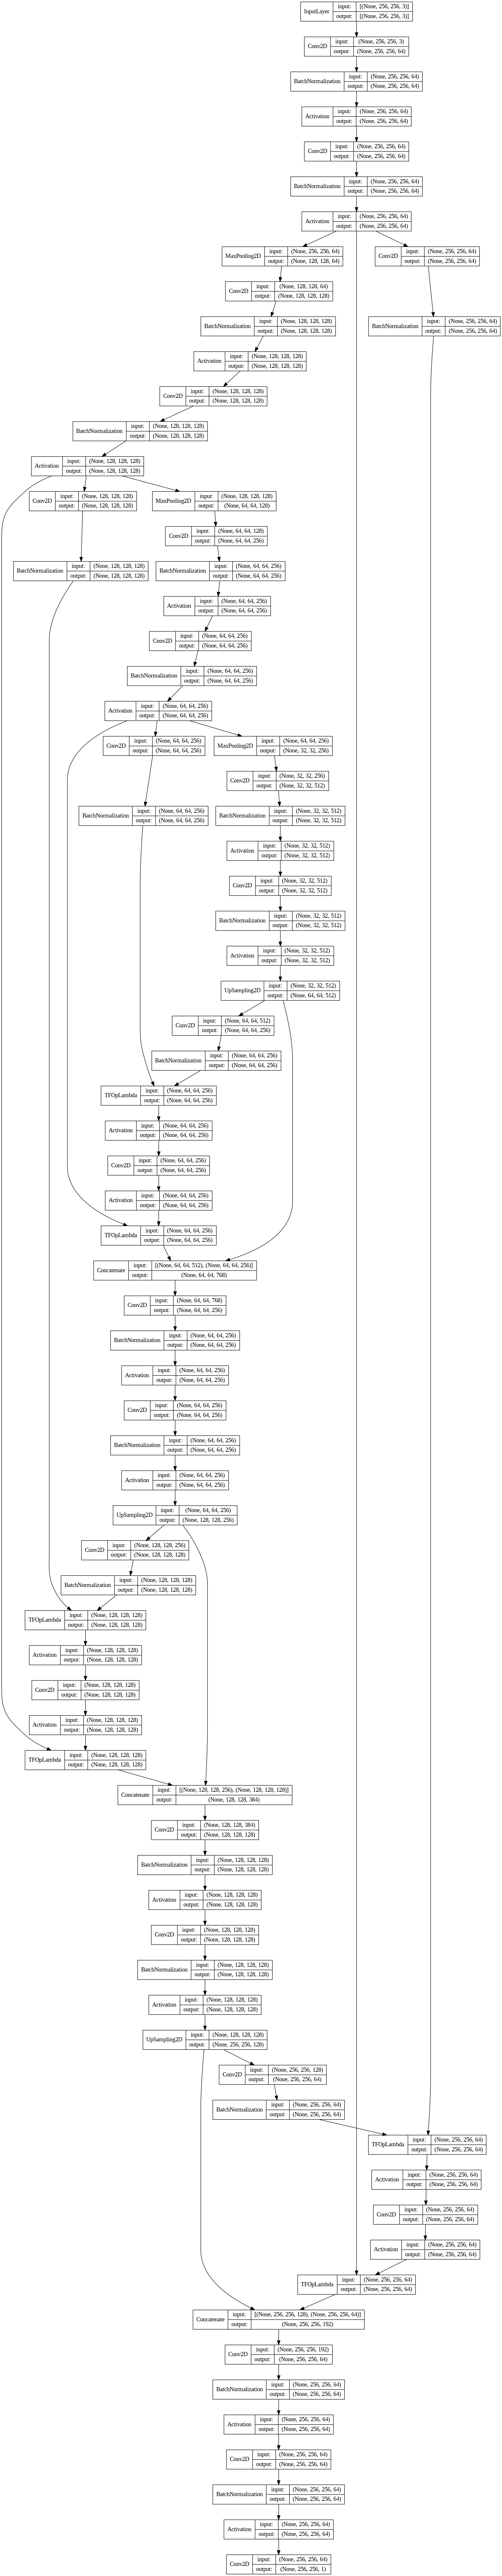

In [24]:
from keras.utils import plot_model
from IPython.display import Image

# Assuming 'model' is your U-Net model
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=False)

Image('unet_model.png')


In [19]:
s=model.fit(
        train_dataset,
        epochs=20,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=0,
    )


Epoch 1: val_loss improved from inf to 0.96539, saving model to files/model.h5

Epoch 2: val_loss did not improve from 0.96539

Epoch 3: val_loss improved from 0.96539 to 0.95578, saving model to files/model.h5

Epoch 4: val_loss improved from 0.95578 to 0.88937, saving model to files/model.h5

Epoch 5: val_loss improved from 0.88937 to 0.69423, saving model to files/model.h5

Epoch 6: val_loss improved from 0.69423 to 0.68407, saving model to files/model.h5

Epoch 7: val_loss improved from 0.68407 to 0.62385, saving model to files/model.h5

Epoch 8: val_loss did not improve from 0.62385

Epoch 9: val_loss improved from 0.62385 to 0.48931, saving model to files/model.h5

Epoch 10: val_loss improved from 0.48931 to 0.47916, saving model to files/model.h5

Epoch 11: val_loss improved from 0.47916 to 0.36382, saving model to files/model.h5

Epoch 12: val_loss did not improve from 0.36382

Epoch 13: val_loss improved from 0.36382 to 0.36061, saving model to files/model.h5

Epoch 14: val_l

In [22]:
import pandas as pd
metrics = pd.read_csv("/content/files/log.csv")
metrics.head(20)

,epoch,accuracy,dice_coef,loss,lr,val_accuracy,val_dice_coef,val_loss
0,0,0.890617,0.156342,0.843658,0.0001,0.982257,0.034541,0.965385
1,1,0.971102,0.256281,0.743719,0.0001,0.981922,0.027141,0.972804
2,2,0.981052,0.337825,0.662175,0.0001,0.916237,0.044999,0.955775
3,3,0.984705,0.416529,0.583471,0.0001,0.949387,0.111531,0.889372
4,4,0.987336,0.487187,0.512813,0.0001,0.975103,0.306570,0.694230
5,5,0.989823,0.563541,0.436459,0.0001,0.953866,0.316337,0.684070
6,6,0.990946,0.620748,0.379252,0.0001,0.982270,0.375497,0.623847
7,7,0.992106,0.675361,0.324639,0.0001,0.986787,0.340308,0.655874
8,8,0.992635,0.710663,0.289337,0.0001,0.988384,0.510795,0.489311
9,9,0.993290,0.743728,0.256272,0.0001,0.988938,0.520800,0.479159


In [23]:
new_column_names = {
    "epoch": "Epoch",
    "accuracy": "Accuracy",
    "dice_coef": "Dice Coefficient",
    "loss":"Loss",
    "lr": "Lr",
    "val_accuracy": "Val Accuracy",
    "val_dice_coef": "Val Dice coefficient",
    "val_loss": "Val Loss"
}

# Rename the columns
metrics = metrics.rename(columns=new_column_names)

# Display the DataFrame with updated column names
metrics



,Epoch,Accuracy,Dice Coefficient,Loss,Lr,Val Accuracy,Val Dice coefficient,Val Loss
0,0,0.890617,0.156342,0.843658,0.0001,0.982257,0.034541,0.965385
1,1,0.971102,0.256281,0.743719,0.0001,0.981922,0.027141,0.972804
2,2,0.981052,0.337825,0.662175,0.0001,0.916237,0.044999,0.955775
3,3,0.984705,0.416529,0.583471,0.0001,0.949387,0.111531,0.889372
4,4,0.987336,0.487187,0.512813,0.0001,0.975103,0.306570,0.694230
5,5,0.989823,0.563541,0.436459,0.0001,0.953866,0.316337,0.684070
6,6,0.990946,0.620748,0.379252,0.0001,0.982270,0.375497,0.623847
7,7,0.992106,0.675361,0.324639,0.0001,0.986787,0.340308,0.655874
8,8,0.992635,0.710663,0.289337,0.0001,0.988384,0.510795,0.489311
9,9,0.993290,0.743728,0.256272,0.0001,0.988938,0.520800,0.479159


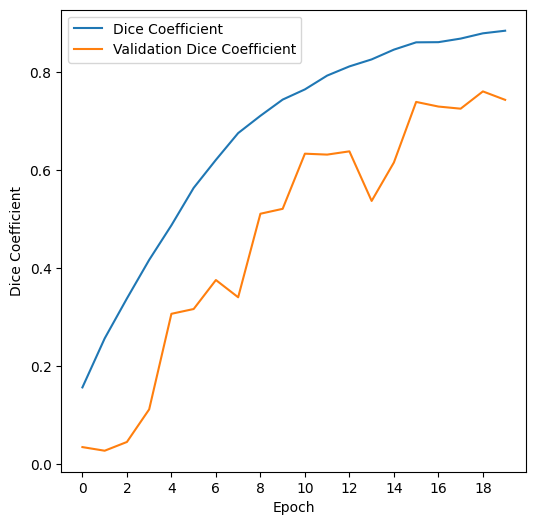

In [27]:
import matplotlib.pyplot as plt

epochs = metrics['Epoch']
dice_coef = metrics['Dice Coefficient']
val_dice_coef = metrics['Val Dice coefficient']

# Create the line plot
plt.figure(figsize=(6, 6))
plt.plot(epochs, dice_coef, label='Dice Coefficient')
plt.plot(epochs, val_dice_coef, label='Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')

plt.legend()

# Display only even numbers on x-axis
even_epochs = epochs[epochs % 2 == 0]
plt.xticks(even_epochs, even_epochs.astype(int))

plt.show()





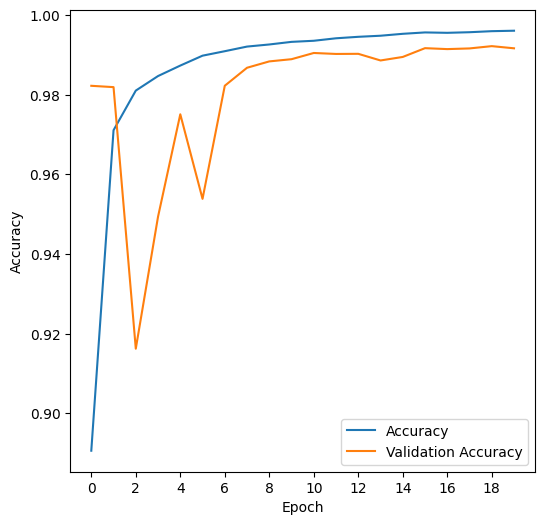

In [29]:
import matplotlib.pyplot as plt

# Assuming metrics is a DataFrame containing accuracy and validation accuracy data
epochs = metrics['Epoch']
accuracy = metrics['Accuracy']
val_accuracy = metrics['Val Accuracy']

# Create the line plot
plt.figure(figsize=(6, 6))
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

# Display only even numbers on x-axis
even_epochs = epochs[epochs % 2 == 0]
plt.xticks(even_epochs, even_epochs.astype(int))

plt.show()



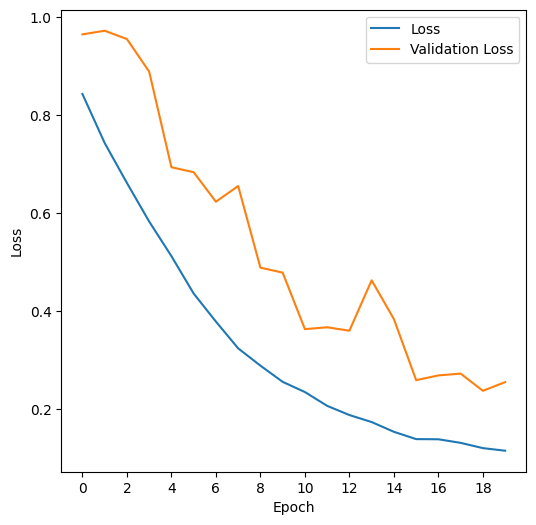

In [30]:
import matplotlib.pyplot as plt

# Assuming metrics is a DataFrame containing loss and validation loss data
epochs = metrics['Epoch']
loss = metrics['Loss']
val_loss = metrics['Val Loss']

# Create the line plot
plt.figure(figsize=(6, 6))
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

# Display only even numbers on x-axis
even_epochs = epochs[epochs % 2 == 0]
plt.xticks(even_epochs, even_epochs.astype(int))

plt.show()


In [31]:
create_dir("results")

In [32]:
from tqdm import tqdm
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [33]:
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv", index=None)

100%|██████████| 612/612 [01:59<00:00,  5.13it/s]

F1: 0.67384
Jaccard: 0.57462
Recall: 0.71192
Precision: 0.71933


In [34]:
scores = pd.read_csv("/content/files/score.csv")
scores.head()

,Image,F1,Jaccard,Recall,Precision
0,833.png,0.846586,0.733983,0.927817,0.778434
1,2069.png,0.873346,0.775168,0.982979,0.785714
2,3038.png,0.502406,0.335476,0.813084,0.363510
3,1169.png,0.952282,0.908911,0.989224,0.918000
4,501.png,0.736842,0.583333,0.989691,0.586900


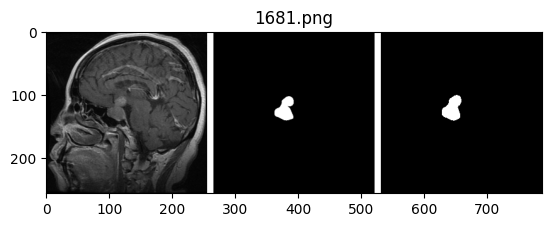

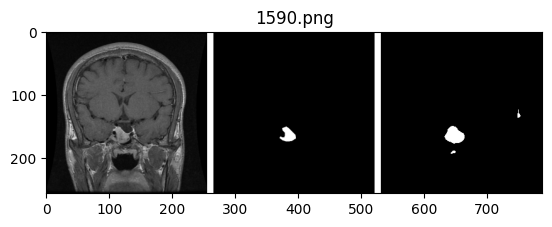

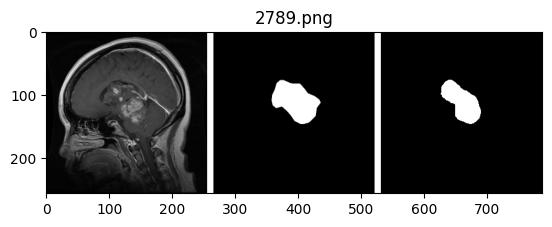

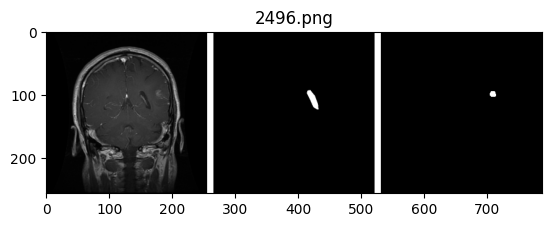

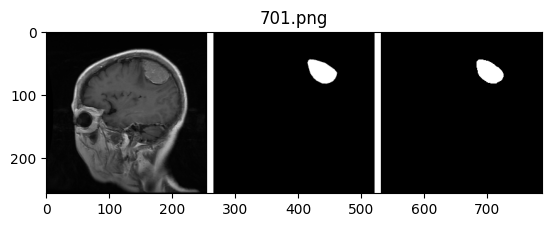

In [36]:
import os
import matplotlib.pyplot as plt

dir = "/content/results"
image_filenames = os.listdir(dir)[6:11]

for filename in image_filenames:
    img_path = os.path.join(dir, filename)
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.show()